# Exploring ensembling different sized models on uncertainty measures 

In [108]:
import pandas as pd
import numpy as np
from scipy.special import rel_entr, entr
import matplotlib.pyplot as plt
from matplotlib_venn import venn3,venn2
import seaborn as sns

In [109]:
# Load data:
df18 = pd.read_csv("../exp2-inf/predictions_res18_2.csv")
df50 = pd.read_csv("../exp2-inf/predictions_res50_2.csv")
df101 = pd.read_csv("../exp2-inf/predictions_res101_2.csv")
label = pd.read_csv("../exp2-inf/labels.csv")
from sklearn.model_selection import train_test_split
val_idx, test_idx = train_test_split(list(range(len(df18))), test_size=0.5, random_state=42)
df18 = df18.iloc[test_idx]
df50 = df50.iloc[test_idx]
df101 = df101.iloc[test_idx]
label = label.iloc[test_idx]

In [110]:
# Load data after ts:
# df18 = pd.read_csv("../exp2-inf/predictions_res50_ts.csv")
# df50 = pd.read_csv("../exp2-inf/predictions_res50_ts.csv")
# df101 = pd.read_csv("../exp2-inf/predictions_res101_ts.csv")
# label = pd.read_csv("../exp2-inf/labels_ts.csv")

In [111]:
num_class = 257
pred = pd.DataFrame({
    "pred18": np.argmax(df18,axis=1),
    "pred50": np.argmax(df50,axis=1),
    "pred101": np.argmax(df101,axis=1),
    "target": label['target']
})
print(f"{df18.shape=}")
display(df18.head(1))
print(f"{df101.shape=}")
display(df101.head(1))
print(f"{pred.shape=}")
display(pred.head(1))

df18.shape=(3061, 257)


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
2095,0.000005,0.000013,0.000019,0.000017,0.000021,0.000006,0.000012,0.993818,0.000088,0.000024,...,0.000002,0.000014,0.000027,0.000017,0.000021,0.000025,0.000013,0.00001,0.000031,0.00001


df101.shape=(3061, 257)


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
2095,0.000012,0.000013,0.000018,0.000009,0.000027,0.000012,0.000012,0.996404,0.000008,0.000009,...,0.000013,0.000005,0.000004,0.00001,0.000012,0.000018,0.000009,0.000017,0.00003,0.000013


pred.shape=(3061, 4)


,pred18,pred50,pred101,target
2095,7,7,7,7


In [112]:
def eval_pred(pred):
    for col in pred.columns.drop("target"):
        acc = (pred[col]==pred["target"]).mean()
        print(f"{col} has accuracy {acc}")
eval_pred(pred)

pred18 has accuracy 0.7608624632473048
pred50 has accuracy 0.8317543286507677
pred101 has accuracy 0.8745508003920287


In [113]:
acc18 = 0.7535
acc101 = 0.8695

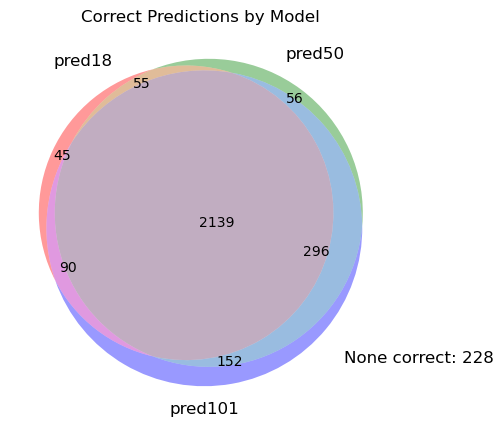

In [114]:
def venn(pred):
    # Accuracy Venn Diagram:
    df = pred
    ls = []
    total_indices = set(df.index)
    incorrect_all = total_indices
    col_names=[]
    for col in df.columns.drop("target"):
        col_names.append(col)
        cor_set = set(df[df[col] == df['target']].index)
        ls.append(cor_set)
        incorrect_all = incorrect_all - cor_set
    plt.figure(figsize=(5,5))
    if len(col_names)==2:
        venn2(ls, col_names)
    elif len(col_names)==3:
        venn3(ls, col_names)
    else:
        raise Exception("Matplotlib Venn only supports 2 or 3 sets, please subset to 3 predictions columns and target.")
    plt.title('Correct Predictions by Model')
    plt.text(0.5, -0.5, f'None correct: {len(incorrect_all)}', fontsize=12)
venn(pred)

# Approach 1: Classical Voting
**Hard Voting (Plurality Voting)**: Selecting the class that receives the most votes as the final prediction. The problem with hard voting here is that we only have two models.  
**Soft Voting (Weighted Voting with uniform weights)**: Calculates the average probability of each class and then declares the winner having the highest weighted probability.  
**Weighted Voting (with validation accuracy as weights)**: Calculates weighted probability of each class based on validation accuracy, and then selecting the class with highest weighted probability

In [115]:
# Soft Voting
def soft_vote(pred1, pred2):
    sum_pred = pred1+pred2
    return np.argmax(sum_pred,axis=1)
pred["soft_vote"] = soft_vote(df18, df101)
display(pred.head(1))
eval_pred(pred)

,pred18,pred50,pred101,target,soft_vote
2095,7,7,7,7,7


pred18 has accuracy 0.7608624632473048
pred50 has accuracy 0.8317543286507677
pred101 has accuracy 0.8745508003920287
soft_vote has accuracy 0.8781443972557987


In [116]:
# pred["soft_vote_3"] = np.argmax(df18+df50+df101,axis=1)
# pred["hard_vote_3"] = np.where((pred["pred101"] != pred["pred18"]) & (pred["pred18"] == pred["pred50"]), pred["pred50"], pred["pred101"])
# eval_pred(pred)

In [117]:
# Weighted Soft Voting
def weighted_vote(pred1, pred2, weight1, weight2):
    weighted_pred = np.multiply(weight1,pred1)+np.multiply(weight2,pred2)
    return np.argmax(weighted_pred,axis=1)
pred["weighted_vote"] = weighted_vote(df18, df101, 0.75, 0.87)
display(pred.head(1))
eval_pred(pred)

,pred18,pred50,pred101,target,soft_vote,weighted_vote
2095,7,7,7,7,7,7


pred18 has accuracy 0.7608624632473048
pred50 has accuracy 0.8317543286507677
pred101 has accuracy 0.8745508003920287
soft_vote has accuracy 0.8781443972557987
weighted_vote has accuracy 0.8774910160078406


In [118]:
# def weighted_vote3(pred1, pred2, pred3, weight1, weight2, weight3):
#     weighted_pred = np.multiply(weight1,pred1)+np.multiply(weight2,pred2)+np.multiply(weight3,pred3)
#     return np.argmax(weighted_pred,axis=1)
# pred["weighted_vote_3"] = weighted_vote3(df18, df50, df101, 0.75, 0.83, 0.87)
# eval_pred(pred)

# Approach 2: Uncertainty Voting
We propose an alternative aggregation strategy based on KL Divergence, Entropy, and Cross Entropy among the two models.

In [119]:
from scipy.special import rel_entr, entr

def calc_kl(P, Q, numclass):
    return np.sum(rel_entr(P.iloc[:, :numclass], Q.iloc[:, :numclass]), axis=1)

# Calculate Entropy
def calc_entropy(P, numclass):
    return np.sum(entr(P.iloc[:, :numclass]), axis=1)

# Calculate Cross-Entropy
def calc_cross_ent(P, Q, numclass):
    return -np.sum(P.iloc[:, :numclass] * np.log(Q.iloc[:, :numclass]), axis=1)

unc_pred = pd.DataFrame()
unc_pred["kl_18_101"] = calc_kl(df18,df101,num_class)
unc_pred["kl_101_18"] = calc_kl(df101,df18,num_class)
unc_pred["kl_18_50"] = calc_kl(df18,df50,num_class)
unc_pred["ent_18"] = calc_entropy(df18,num_class)
unc_pred["ent_50"] = calc_entropy(df50,num_class)
unc_pred["ent_101"] = calc_entropy(df101,num_class)
unc_pred["ce_18_101"] = calc_cross_ent(df18,df101,num_class)
unc_pred["ce_101_18"] = calc_cross_ent(df101,df18,num_class)

unc_pred.head()

,kl_18_101,kl_101_18,kl_18_50,ent_18,ent_50,ent_101,ce_18_101,ce_101_18
2095,0.005454,0.003145,0.053256,0.066042,0.612255,0.041488,0.071496,0.044633
3693,2.549316,0.915429,1.791443,3.886930,0.289423,0.110614,6.436246,1.026043
1803,0.739175,0.261443,0.260292,1.947661,0.750342,0.117020,2.686836,0.378463
4296,2.473712,2.601213,3.109485,5.076013,0.850889,2.089456,7.549725,4.690669
2572,0.080690,0.020294,0.035534,0.222456,0.052965,0.009736,0.303146,0.030031


**Method 1** We select the prediction of the model with lower entropy (i.e. lower uncertainty) This is a flavor of hard voting, as in it is not going to predict anything that isn't already a top prediction of either model.

pred18 has accuracy 0.7608624632473048
pred50 has accuracy 0.8317543286507677
pred101 has accuracy 0.8745508003920287
soft_vote has accuracy 0.8781443972557987
weighted_vote has accuracy 0.8774910160078406
min_entropy_pred has accuracy 0.8752041816399869


/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


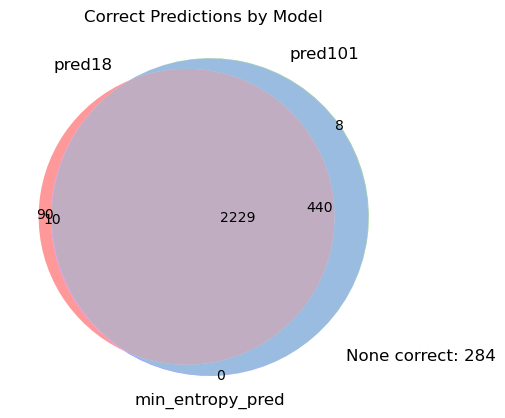

In [120]:
pred["min_entropy_pred"] = np.where(unc_pred["ent_18"]>unc_pred["ent_101"],pred["pred101"],pred["pred18"])
pred.head(1)
eval_pred(pred)
venn(pred[["pred18","pred101","min_entropy_pred","target"]])

**Method 2** We combine the predictions of models by assigning the other model's entropy as weights, i.e a model receives more weights when the other models is uncertain.

In [121]:
def vec_weighted_vote(pred1, pred2, weightvec1, weightvec2):
    weighted_pred = pred1.mul(weightvec1, axis=0) + pred2.mul(weightvec2, axis=0)
    return np.argmax(weighted_pred,axis=1)

def vec_weighted_vote3(pred1, pred2, pred3, weightvec1, weightvec2, weightvec3):
    weighted_pred = pred1.mul(weightvec1, axis=0) + pred2.mul(weightvec2, axis=0) + pred3.mul(weightvec3, axis=0)
    return np.argmax(weighted_pred,axis=1)

pred["unc_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"], unc_pred["ent_18"])

display(pred.head(1))
# eval_pred(pred)

,pred18,pred50,pred101,target,soft_vote,weighted_vote,min_entropy_pred,unc_weighted_vote
2095,7,7,7,7,7,7,7,7


In [122]:
pred["kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"], unc_pred["kl_18_101"])
display(pred.head(1))
# eval_pred(pred)
# venn(pred[["target","pred18","pred101","kl_weighted_vote"]])

,pred18,pred50,pred101,target,soft_vote,weighted_vote,min_entropy_pred,unc_weighted_vote,kl_weighted_vote
2095,7,7,7,7,7,7,7,7,7


In [123]:
# pred["kl_weighted_vote_3"] = vec_weighted_vote3(df18,df50, df101, unc_pred["kl_101_18"],unc_pred["kl_18_50"], unc_pred["kl_18_101"])
# pred["ent_weighted_vote_3"] = vec_weighted_vote3(df18,df50, df101, unc_pred["ent_101"],unc_pred["ent_50"], unc_pred["ent_18"])
# eval_pred(pred)

In [124]:
pred["ce_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ce_101_18"], unc_pred["ce_18_101"])
display(pred.head(1))
# eval_pred(pred)
# venn(pred[["target","pred18","pred101","kl_weighted_vote"]])

,pred18,pred50,pred101,target,soft_vote,weighted_vote,min_entropy_pred,unc_weighted_vote,kl_weighted_vote,ce_weighted_vote
2095,7,7,7,7,7,7,7,7,7,7


In [125]:
pred["kl_sqr_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**2, unc_pred["kl_18_101"]**2)
display(pred.head(1))
# eval_pred(pred)

,pred18,pred50,pred101,target,soft_vote,weighted_vote,min_entropy_pred,unc_weighted_vote,kl_weighted_vote,ce_weighted_vote,kl_sqr_weighted_vote
2095,7,7,7,7,7,7,7,7,7,7,7


In [126]:
pred["kl_acc_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**acc18, unc_pred["kl_18_101"]**acc101)
display(pred.head(1))
# eval_pred(pred)

,pred18,pred50,pred101,target,soft_vote,weighted_vote,min_entropy_pred,unc_weighted_vote,kl_weighted_vote,ce_weighted_vote,kl_sqr_weighted_vote,kl_acc_weighted_vote
2095,7,7,7,7,7,7,7,7,7,7,7,7


In [127]:
pred["ent_kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"]**unc_pred["kl_101_18"], unc_pred["ent_18"]**unc_pred["kl_18_101"])
display(pred.head(1))

,pred18,pred50,pred101,target,soft_vote,weighted_vote,min_entropy_pred,unc_weighted_vote,kl_weighted_vote,ce_weighted_vote,kl_sqr_weighted_vote,kl_acc_weighted_vote,ent_kl_weighted_vote
2095,7,7,7,7,7,7,7,7,7,7,7,7,7


In [128]:
pred["kl_ent_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**unc_pred["ent_101"], unc_pred["kl_18_101"]**unc_pred["ent_18"])
display(pred.head(1))
eval_pred(pred)

,pred18,pred50,pred101,target,soft_vote,weighted_vote,min_entropy_pred,unc_weighted_vote,kl_weighted_vote,ce_weighted_vote,kl_sqr_weighted_vote,kl_acc_weighted_vote,ent_kl_weighted_vote,kl_ent_weighted_vote
2095,7,7,7,7,7,7,7,7,7,7,7,7,7,7


pred18 has accuracy 0.7608624632473048
pred50 has accuracy 0.8317543286507677
pred101 has accuracy 0.8745508003920287
soft_vote has accuracy 0.8781443972557987
weighted_vote has accuracy 0.8774910160078406
min_entropy_pred has accuracy 0.8752041816399869
unc_weighted_vote has accuracy 0.8774910160078406
kl_weighted_vote has accuracy 0.8784710878797779
ce_weighted_vote has accuracy 0.8774910160078406
kl_sqr_weighted_vote has accuracy 0.878797778503757
kl_acc_weighted_vote has accuracy 0.8794511597517152
ent_kl_weighted_vote has accuracy 0.878797778503757
kl_ent_weighted_vote has accuracy 0.878797778503757


/Users/timothyzhou/anaconda3/envs/cpsc340/lib/python3.11/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


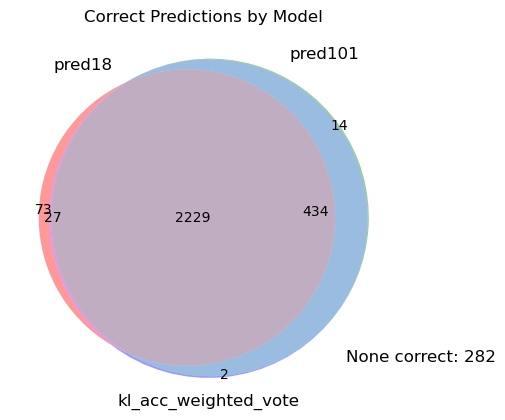

In [129]:
venn(pred[["target","pred18","pred101","kl_acc_weighted_vote"]])

In [130]:
unc_pred.head()

,kl_18_101,kl_101_18,kl_18_50,ent_18,ent_50,ent_101,ce_18_101,ce_101_18
2095,0.005454,0.003145,0.053256,0.066042,0.612255,0.041488,0.071496,0.044633
3693,2.549316,0.915429,1.791443,3.886930,0.289423,0.110614,6.436246,1.026043
1803,0.739175,0.261443,0.260292,1.947661,0.750342,0.117020,2.686836,0.378463
4296,2.473712,2.601213,3.109485,5.076013,0.850889,2.089456,7.549725,4.690669
2572,0.080690,0.020294,0.035534,0.222456,0.052965,0.009736,0.303146,0.030031


In [131]:
def calc_tpr(targ, pred):
    tp = np.sum((targ == 1) & (pred == 1))
    fn = np.sum((targ == 1) & (pred == 0))
    return tp / (tp + fn)
def calc_fpr(targ, pred):
    fp = np.sum((targ == 0) & (pred == 1))
    tn = np.sum((targ == 0) & (pred == 0))
    return fp / (fp + tn)
def predict_correctness(ent_ls,threshold):
    return np.where(ent_ls>threshold,0,1)

max_ent=5.4707640691693005||min_ent=0.0012443204783566303


,pred18,target,ent_18,cor_18
2095,7,7,0.066042,1
3693,157,157,3.886930,1


<Axes: >

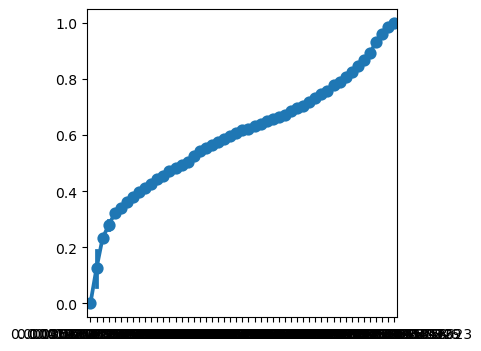

In [132]:
# Entropy 18
prep_roc18 = pred[["pred18", "target"]].copy()
prep_roc18["ent_18"] = unc_pred["ent_18"]
prep_roc18["cor_18"] = np.where(prep_roc18["pred18"]==prep_roc18["target"],1,0)
max_ent = prep_roc18["ent_18"].max()
min_ent = prep_roc18["ent_18"].min()
print(f"{max_ent=}||{min_ent=}")
display(prep_roc18.head(2))
tpr = np.array([])
fpr=np.array([])
for ent_step in np.arange(min_ent,max_ent,0.1):
    temp = predict_correctness(prep_roc18["ent_18"],ent_step)
    tpr= np.append(tpr,calc_tpr(prep_roc18["cor_18"],temp))
    fpr= np.append(fpr, calc_fpr(prep_roc18["cor_18"],temp))
plt.figure(figsize=(4,4))
sns.pointplot(x=fpr,y=tpr)

max_ent=5.354127645330788||min_ent=0.0011229494420059189


,pred101,target,ent_101,cor_101
2095,7,7,0.041488,1
3693,157,157,0.110614,1


<Axes: >

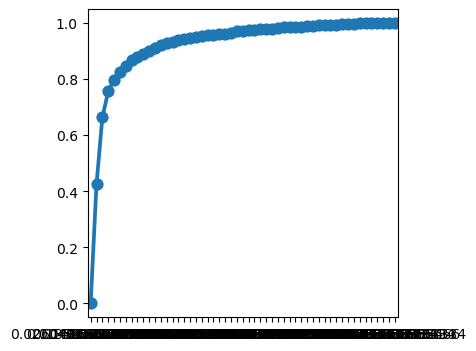

In [133]:
# Entropy 101
prep_roc101 = pred[["pred101", "target"]].copy()
prep_roc101["ent_101"] = unc_pred["ent_101"]
prep_roc101["cor_101"] = np.where(prep_roc101["pred101"]==prep_roc101["target"],1,0)
max_ent = prep_roc101["ent_101"].max()
min_ent = prep_roc101["ent_101"].min()
print(f"{max_ent=}||{min_ent=}")
display(prep_roc101.head(2))
tpr = np.array([]) 
fpr=np.array([])
for ent_step in np.arange(min_ent,max_ent,0.1):
    temp = predict_correctness(prep_roc101["ent_101"],ent_step)
    tpr= np.append(tpr,calc_tpr(prep_roc101["cor_101"],temp))
    fpr= np.append(fpr, calc_fpr(prep_roc101["cor_101"],temp))
plt.figure(figsize=(4,4))
sns.pointplot(x=fpr,y=tpr)

In [134]:
# roc = pd.DataFrame({
#     "fpr":fpr,
#     "tpr":tpr
# })
# epsilon = 0.001
# roc["tpr_over_fpr"] = (1-roc["tpr"])*(roc["fpr"]+epsilon)
# display(roc.head(2))
# # best_threshold = np.arange(min_ent,max_ent,0.1)[np.argmin(roc["tpr_over_fpr"])]
# best_threshold = 4
# print(f"{best_threshold=}")
# pred["entropy101_maxroc_vote"] = np.where(unc_pred["ent_101"]<=best_threshold, pred["pred101"],pred["pred18"])
# display(pred.head(1))
# eval_pred(pred)
# venn(pred[["target","pred18","pred101","entropy101_maxroc_vote"]])

max_ent=8.696957489755945||min_ent=0.00077365487509927


,pred101,target,kl_101_18,cor_101
2095,7,7,0.003145,1
3693,157,157,0.915429,1


<Axes: >

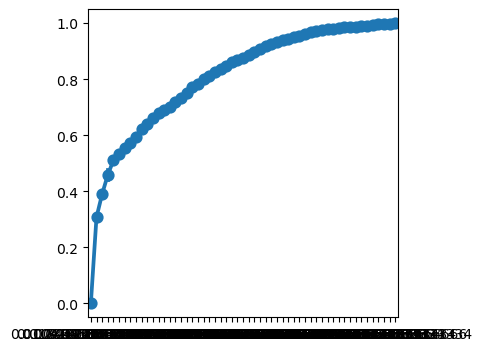

In [135]:
prep_roc101 = pred[["pred101", "target"]].copy()
prep_roc101["kl_101_18"] = unc_pred["kl_101_18"]
prep_roc101["cor_101"] = np.where(prep_roc101["pred101"]==prep_roc101["target"],1,0)
max_ent = prep_roc101["kl_101_18"].max()
min_ent = prep_roc101["kl_101_18"].min()
print(f"{max_ent=}||{min_ent=}")
display(prep_roc101.head(2))
tpr = np.array([]) 
fpr=np.array([])
for ent_step in np.arange(min_ent,max_ent,0.1):
    temp = predict_correctness(prep_roc101["kl_101_18"],ent_step)
    tpr= np.append(tpr,calc_tpr(prep_roc101["cor_101"],temp))
    fpr= np.append(fpr, calc_fpr(prep_roc101["cor_101"],temp))
plt.figure(figsize=(4,4))
sns.pointplot(x=fpr,y=tpr)

max_ent=10.509523404185035||min_ent=0.001332480281230937


,pred101,target,kl_18_101,cor_101
2095,7,7,0.005454,1
3693,157,157,2.549316,1


<Axes: >

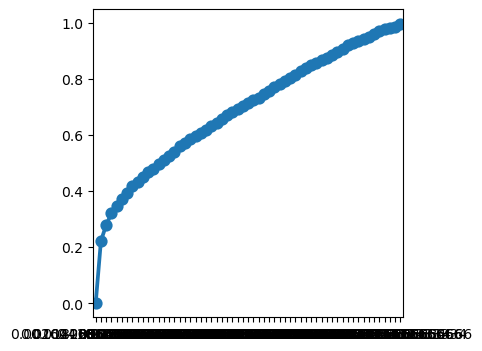

In [136]:
prep_roc101 = pred[["pred101", "target"]].copy()
prep_roc101["kl_18_101"] = unc_pred["kl_18_101"]
prep_roc101["cor_101"] = np.where(prep_roc101["pred101"]==prep_roc101["target"],1,0)
max_ent = prep_roc101["kl_18_101"].max()
min_ent = prep_roc101["kl_18_101"].min()
print(f"{max_ent=}||{min_ent=}")
display(prep_roc101.head(2))
tpr = np.array([]) 
fpr=np.array([])
for ent_step in np.arange(min_ent,max_ent,0.1):
    temp = predict_correctness(prep_roc101["kl_18_101"],ent_step)
    tpr= np.append(tpr,calc_tpr(prep_roc101["cor_101"],temp))
    fpr= np.append(fpr, calc_fpr(prep_roc101["cor_101"],temp))
plt.figure(figsize=(4,4))
sns.pointplot(x=fpr,y=tpr)

In [137]:
display(df18.head(1))
display(df50.head(1))
display(df101.head(1))
display(pred.head(1))
display(unc_pred.head(1))
unc_pred.shape

,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
2095,0.000005,0.000013,0.000019,0.000017,0.000021,0.000006,0.000012,0.993818,0.000088,0.000024,...,0.000002,0.000014,0.000027,0.000017,0.000021,0.000025,0.000013,0.00001,0.000031,0.00001


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
2095,0.000209,0.000354,0.000134,0.000203,0.000268,0.000119,0.000159,0.932014,0.000284,0.000182,...,0.00022,0.000483,0.000343,0.000384,0.000209,0.000334,0.000308,0.000252,0.000172,0.000186


,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,...,class_247,class_248,class_249,class_250,class_251,class_252,class_253,class_254,class_255,class_256
2095,0.000012,0.000013,0.000018,0.000009,0.000027,0.000012,0.000012,0.996404,0.000008,0.000009,...,0.000013,0.000005,0.000004,0.00001,0.000012,0.000018,0.000009,0.000017,0.00003,0.000013


,pred18,pred50,pred101,target,soft_vote,weighted_vote,min_entropy_pred,unc_weighted_vote,kl_weighted_vote,ce_weighted_vote,kl_sqr_weighted_vote,kl_acc_weighted_vote,ent_kl_weighted_vote,kl_ent_weighted_vote
2095,7,7,7,7,7,7,7,7,7,7,7,7,7,7


,kl_18_101,kl_101_18,kl_18_50,ent_18,ent_50,ent_101,ce_18_101,ce_101_18
2095,0.005454,0.003145,0.053256,0.066042,0.612255,0.041488,0.071496,0.044633


(3061, 8)

In [138]:
df18.to_csv("./data/df18.csv",header=True,index=True)
df50.to_csv("./data/df50.csv",header=True,index=True)
df101.to_csv("./data/df101.csv",header=True,index=True)
pred.to_csv("./data/pred.csv",header=True,index=True)
unc_pred.to_csv("./data/unc_pred.csv",header=True,index=True)